# **Android App Market Analyzing Google Play Store Data**

**Import Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


**Read CSV Files**

In [2]:
# Define file paths
apps_file_path = r"C:\Users\Rohan\Desktop\Datasets\android datasets\apps.csv"
user_reviews_file_path = r"C:\Users\Rohan\Desktop\Datasets\android datasets\user_reviews.csv"

# Read the datasets
apps_df = pd.read_csv(apps_file_path)
user_reviews_df = pd.read_csv(user_reviews_file_path)

# Display the first few rows of each DataFrame
apps_df.head(), user_reviews_df.head()


(   Unnamed: 0                                                App  \
 0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
 1           1                                Coloring book moana   
 2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
 3           3                              Sketch - Draw & Paint   
 4           4              Pixel Draw - Number Art Coloring Book   
 
          Category  Rating  Reviews  Size     Installs  Type Price  \
 0  ART_AND_DESIGN     4.1      159  19.0      10,000+  Free     0   
 1  ART_AND_DESIGN     3.9      967  14.0     500,000+  Free     0   
 2  ART_AND_DESIGN     4.7    87510   8.7   5,000,000+  Free     0   
 3  ART_AND_DESIGN     4.5   215644  25.0  50,000,000+  Free     0   
 4  ART_AND_DESIGN     4.3      967   2.8     100,000+  Free     0   
 
   Content Rating                     Genres      Last Updated  \
 0       Everyone               Art & Design   January 7, 2018   
 1       Everyone  Art & Desig

**Data Preparation**

In [3]:
# First, handle missing values in 'Size'
apps_df['Size'] = apps_df['Size'].replace('Varies with device', None)

# Convert non-null 'Size' values to string for string operations
apps_df['Size'] = apps_df['Size'].astype(str)

# Replace 'M' for Megabytes and 'k' for Kilobytes
# We'll multiply kilobytes values by 0.001 to convert them to Megabytes
def size_to_float(size):
    if 'M' in size:
        return float(size.replace('M', ''))
    elif 'k' in size:
        return float(size.replace('k', '')) * 0.001
    else:
        return None  # For cases where 'Size' is not provided

# Apply the conversion function to the 'Size' column
apps_df['Size'] = apps_df['Size'].apply(size_to_float)

# Check the cleaned DataFrame
apps_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            0 non-null      object 
 6   Installs        9659 non-null   object 
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   object 
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 1.0+ MB


**Category Exploration**

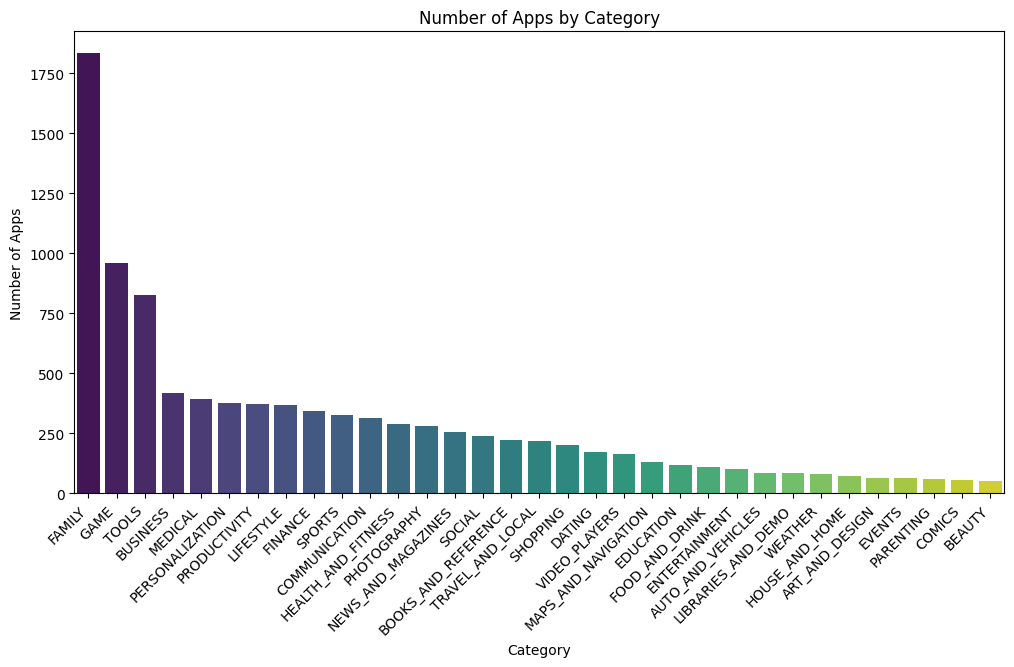

In [4]:
# Count the number of apps in each category
category_counts = apps_df['Category'].value_counts()

# Plot the distribution of apps by category
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values,hue= category_counts.index, palette='viridis')
plt.title('Number of Apps by Category')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Number of Apps')
plt.show()


**Metrics Analysis**

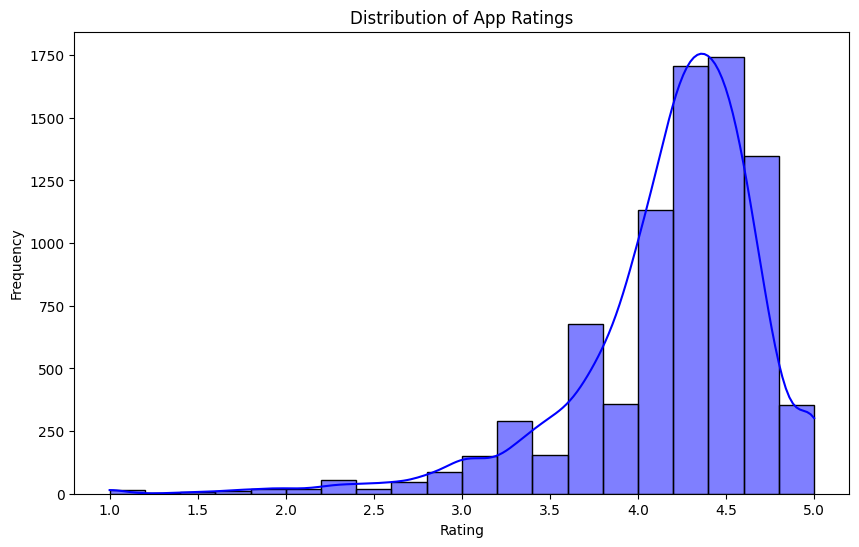

In [5]:
# Plotting Rating Distribution
plt.figure(figsize=(10, 6))
sns.histplot(apps_df['Rating'], bins=20, kde=True, color='blue')
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


**Inspect the 'Size' Column**

In [6]:
# Check unique values in 'Size' after initial cleaning
print("Unique values in 'Size' after initial cleaning:")
print(apps_df['Size'].unique())


Unique values in 'Size' after initial cleaning:
[None]


**Comprehensive Cleaning of the 'Size' Column**

In [7]:
import numpy as np

# Define a comprehensive function to convert 'Size' to float (in MB)
def convert_size(size_str):
    if isinstance(size_str, str):
        size_str = size_str.strip()
        if size_str.endswith('M'):
            try:
                return float(size_str[:-1])
            except:
                return np.nan
        elif size_str.endswith('k'):
            try:
                return float(size_str[:-1]) / 1024  # Convert kB to MB
            except:
                return np.nan
        elif size_str.endswith('G'):
            try:
                return float(size_str[:-1]) * 1024  # Convert GB to MB
            except:
                return np.nan
        else:
            return np.nan
    else:
        return np.nan

# Apply the conversion function to the 'Size' column
apps_df['Size_MB'] = apps_df['Size'].apply(convert_size)

# Display unique values after conversion to ensure all are numeric
print("Unique values in 'Size_MB':")
print(apps_df['Size_MB'].unique())


Unique values in 'Size_MB':
[nan]


**Verify the Cleaning Process**

In [8]:
# Check for missing values in 'Size_MB' and 'Rating'
print("Missing values in 'Size_MB':", apps_df['Size_MB'].isna().sum())
print("Missing values in 'Rating':", apps_df['Rating'].isna().sum())

# Basic statistics
print("\nStatistics for 'Size_MB':")
print(apps_df['Size_MB'].describe())

print("\nStatistics for 'Rating':")
print(apps_df['Rating'].describe())


Missing values in 'Size_MB': 9659
Missing values in 'Rating': 1463

Statistics for 'Size_MB':
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Size_MB, dtype: float64

Statistics for 'Rating':
count    8196.000000
mean        4.173243
std         0.536625
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64


**Drop Rows with Missing or Invalid Values**

In [9]:
# Drop rows with missing 'Size_MB' or 'Rating'
apps_df_clean = apps_df.dropna(subset=['Size_MB', 'Rating'])

# Additionally, filter out any non-sensical values
apps_df_clean = apps_df_clean[
    (apps_df_clean['Size_MB'] > 0) &
    (apps_df_clean['Rating'] >= 0) &
    (apps_df_clean['Rating'] <= 5)
]

# Verify the cleaned DataFrame
print("\nCleaned DataFrame info:")
apps_df_clean.info()

# Display some rows to verify
apps_df_clean[['App', 'Size_MB', 'Rating', 'Category']].head()



Cleaned DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      0 non-null      int64  
 1   App             0 non-null      object 
 2   Category        0 non-null      object 
 3   Rating          0 non-null      float64
 4   Reviews         0 non-null      int64  
 5   Size            0 non-null      object 
 6   Installs        0 non-null      object 
 7   Type            0 non-null      object 
 8   Price           0 non-null      object 
 9   Content Rating  0 non-null      object 
 10  Genres          0 non-null      object 
 11  Last Updated    0 non-null      object 
 12  Current Ver     0 non-null      object 
 13  Android Ver     0 non-null      object 
 14  Size_MB         0 non-null      float64
dtypes: float64(2), int64(2), object(11)
memory usage: 0.0+ bytes


,App,Size_MB,Rating,Category


**Confirm Data Availability**

In [10]:
print("\nNumber of apps after cleaning:", len(apps_df_clean))



Number of apps after cleaning: 0


In [11]:
# Example cleaning step that might be causing the issue
apps_df_clean = apps_df.dropna()  # This drops rows with missing values


In [12]:
print("Number of apps before cleaning:", len(apps_df))

# Apply one cleaning step at a time and check the results
apps_df_clean = apps_df.dropna()  # Or other cleaning steps
print("Number of apps after dropping missing values:", len(apps_df_clean))


Number of apps before cleaning: 9659
Number of apps after dropping missing values: 0


In [13]:
print(apps_df.isna().sum())  # This will show the count of missing values per column


Unnamed: 0           0
App                  0
Category             0
Rating            1463
Reviews              0
Size              9659
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
Size_MB           9659
dtype: int64


In [14]:
apps_df_clean = apps_df.dropna(subset=['Rating'])  # Drops only rows where 'Rating' is missing
print("Number of apps after dropping missing ratings:", len(apps_df_clean))


Number of apps after dropping missing ratings: 8196


In [15]:
import pandas as pd
import numpy as np

# Example DataFrame (replace with your actual DataFrame)
# apps_df = pd.read_csv('your_file.csv')

# Display initial information
print("Initial DataFrame info:")
print(apps_df.info())

# Check for missing values before any operations
print("Missing values before cleaning:")
print(apps_df[['Rating', 'Size']].isnull().sum())

# Clean 'Size' column by replacing non-numeric values
apps_df['Size'] = apps_df['Size'].replace('Varies with device', np.nan)

# Convert 'Size' to numeric (this will convert non-convertible entries to NaN)
apps_df['Size'] = pd.to_numeric(apps_df['Size'], errors='coerce')

# Check the number of missing values again
print("Missing values after cleaning Size:")
print(apps_df[['Rating', 'Size']].isnull().sum())

# Fill missing ratings only if the column is not empty
if not apps_df['Rating'].isnull().all():
    apps_df['Rating'] = apps_df['Rating'].fillna(apps_df['Rating'].mean())

# Fill missing sizes only if the column is not empty
if not apps_df['Size'].isnull().all():
    apps_df['Size'] = apps_df['Size'].fillna(apps_df['Size'].median())

# Final check
print("Missing values after filling:")
print(apps_df[['Rating', 'Size']].isnull().sum())
print("Final DataFrame info:")
print(apps_df.info())


Initial DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            0 non-null      object 
 6   Installs        9659 non-null   object 
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   object 
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
 14  Size_MB         0 non-null      float64
dtypes: float64(2), int64(2), object(11)
memory usage: 1.1+ MB
None
Missing values before cleaning:
Rati

In [16]:
print(apps_df[apps_df['Rating'].isna()])  # Print rows with missing ratings
print(apps_df[apps_df['Size'].isna()])    # Print rows with missing sizes


Empty DataFrame
Columns: [Unnamed: 0, App, Category, Rating, Reviews, Size, Installs, Type, Price, Content Rating, Genres, Last Updated, Current Ver, Android Ver, Size_MB]
Index: []
      Unnamed: 0                                                App  \
0              0     Photo Editor & Candy Camera & Grid & ScrapBook   
1              1                                Coloring book moana   
2              2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3              3                              Sketch - Draw & Paint   
4              4              Pixel Draw - Number Art Coloring Book   
...          ...                                                ...   
9654       10836                                   Sya9a Maroc - FR   
9655       10837                   Fr. Mike Schmitz Audio Teachings   
9656       10838                             Parkinson Exercices FR   
9657       10839                      The SCP Foundation DB fr nn5n   
9658       10840      iHoroscope - 20

**Sentiment Analysis**

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Missing values in Translated_Review: 0


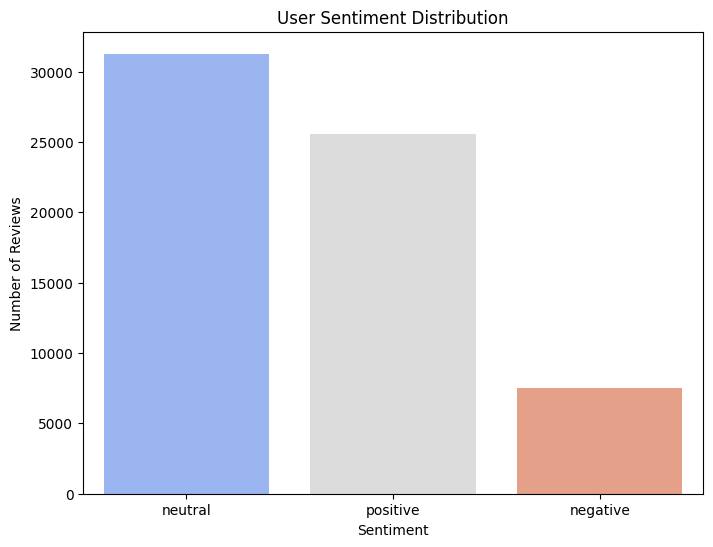

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon if not already done
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Check for missing values
print("Missing values in Translated_Review:", user_reviews_df['Translated_Review'].isnull().sum())

# Convert non-string values in 'Translated_Review' to empty strings
user_reviews_df['Translated_Review'] = user_reviews_df['Translated_Review'].astype(str)

# Calculate sentiment scores
user_reviews_df['compound'] = user_reviews_df['Translated_Review'].apply(lambda x: sia.polarity_scores(x)['compound'])
user_reviews_df['sentiment'] = user_reviews_df['compound'].apply(
    lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')
)

# Display sentiment distribution
sentiment_counts = user_reviews_df['sentiment'].value_counts()

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values,hue=sentiment_counts.index, palette='coolwarm')
plt.title('User Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


**Interactive Visualization**

**Create an Interactive Scatter Plot**

   Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating  Reviews  Size  Installs  Type Price Content Rating  \
0  ART_AND_DESIGN     4.1      159   NaN         0  Free     0       Everyone   
1  ART_AND_DESIGN     3.9      967   NaN         0  Free     0       Everyone   
2  ART_AND_DESIGN     4.7    87510   NaN         0  Free     0       Everyone   
3  ART_AND_DESIGN     4.5   215644   NaN         0  Free     0           Teen   
4  ART_AND_DESIGN     4.3      967   NaN         0  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   Jan

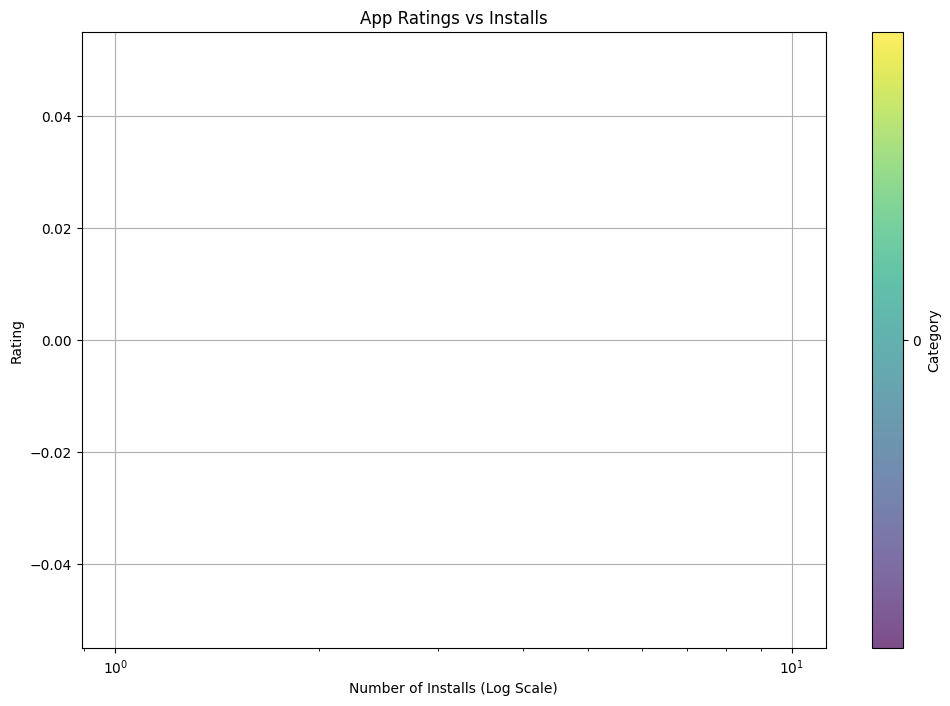

In [20]:
import matplotlib.pyplot as plt
import mplcursors
import pandas as pd

# Sample DataFrame loading
# apps_df = pd.read_csv('your_data.csv')  # Load your data here

# Check the data types and content
print(apps_df.head())
print(apps_df.dtypes)
print(apps_df[['Installs', 'Rating', 'Size']].isnull().sum())

# Convert Installs to numeric, handling any non-numeric values
if apps_df['Installs'].dtype != 'object':
    apps_df['Installs'] = apps_df['Installs'].astype(str)

apps_df['Installs'] = pd.to_numeric(apps_df['Installs'].str.replace(',', '', regex=False), errors='coerce')
apps_df['Installs'] = apps_df['Installs'].fillna(0).astype(int)

# Convert Size to numeric, handling any non-numeric values
apps_df['Size'] = pd.to_numeric(apps_df['Size'], errors='coerce')
apps_df['Size'] = apps_df['Size'].fillna(apps_df['Size'].median())

# Check value ranges
print(apps_df['Installs'].min(), apps_df['Installs'].max())
print(apps_df['Rating'].min(), apps_df['Rating'].max())
print(apps_df['Size'].min(), apps_df['Size'].max())

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(apps_df['Installs'], apps_df['Rating'], 
                      c=apps_df['Category'].astype('category').cat.codes, 
                      s=apps_df['Size'] * 10, alpha=0.7)

# Create a color bar
plt.colorbar(scatter, ticks=range(len(apps_df['Category'].unique())), label='Category', format='%d')

# Adding titles and labels
plt.title('App Ratings vs Installs')
plt.xlabel('Number of Installs (Log Scale)')
plt.ylabel('Rating')

# Use logarithmic scale for x-axis if necessary
plt.xscale('log')

# Create interactive annotations with mplcursors
mplcursors.cursor(scatter, hover=True).connect("add", lambda sel: sel.annotation.set_text(apps_df['App'].iloc[sel.index]))

# Show the plot
plt.grid(True)
plt.show()
import warnings
warnings.filterwarnings('ignore')


In [21]:
# Display the first few rows to understand the data structure
print("DataFrame Head:")
print(apps_df.head())

# Check for NaN values in relevant columns
print("\nMissing Values:")
print(apps_df[['Installs', 'Rating', 'Size']].isnull().sum())

# Check unique values in relevant columns
print("\nUnique Values:")
print("Installs:", apps_df['Installs'].unique())
print("Rating:", apps_df['Rating'].unique())
print("Size:", apps_df['Size'].unique())


DataFrame Head:
   Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating  Reviews  Size  Installs  Type Price Content Rating  \
0  ART_AND_DESIGN     4.1      159   NaN         0  Free     0       Everyone   
1  ART_AND_DESIGN     3.9      967   NaN         0  Free     0       Everyone   
2  ART_AND_DESIGN     4.7    87510   NaN         0  Free     0       Everyone   
3  ART_AND_DESIGN     4.5   215644   NaN         0  Free     0           Teen   
4  ART_AND_DESIGN     4.3      967   NaN         0  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Ar

In [22]:
# Verify data types of the relevant columns
print("\nData Types:")
print(apps_df.dtypes)

# Verify numeric conversions
print("\nConverted Values:")
print(apps_df[['Installs', 'Rating', 'Size']].describe())



Data Types:
Unnamed: 0          int64
App                object
Category           object
Rating            float64
Reviews             int64
Size              float64
Installs            int64
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
Size_MB           float64
dtype: object

Converted Values:
       Installs       Rating  Size
count    9659.0  9659.000000   0.0
mean        0.0     4.173243   NaN
std         0.0     0.494312   NaN
min         0.0     1.000000   NaN
25%         0.0     4.000000   NaN
50%         0.0     4.200000   NaN
75%         0.0     4.500000   NaN
max         0.0     5.000000   NaN


In [23]:
# Check ranges
print("\nValue Ranges:")
print(f"Installs Range: {apps_df['Installs'].min()} to {apps_df['Installs'].max()}")
print(f"Rating Range: {apps_df['Rating'].min()} to {apps_df['Rating'].max()}")
print(f"Size Range: {apps_df['Size'].min()} to {apps_df['Size'].max()}")



Value Ranges:
Installs Range: 0 to 0
Rating Range: 1.0 to 5.0
Size Range: nan to nan


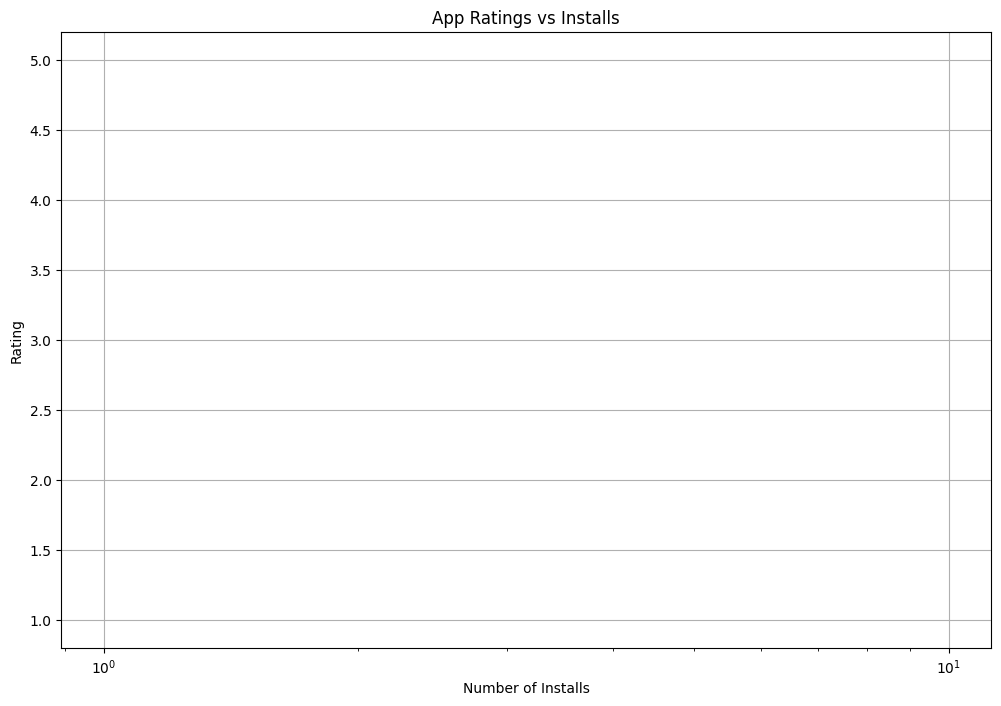

In [24]:
# Basic scatter plot without interactive features
plt.figure(figsize=(12, 8))

# Plotting only Rating vs Installs without color or size
plt.scatter(apps_df['Installs'], apps_df['Rating'], alpha=0.7)

# Adding titles and labels
plt.title('App Ratings vs Installs')
plt.xlabel('Number of Installs')
plt.ylabel('Rating')

# Show the plot
plt.grid(True)
plt.xscale('log')  # Use log scale for better visibility of large ranges
plt.show()



Axis Limits:
x-axis limits: (np.float64(0.0), np.float64(1.0))
y-axis limits: (np.float64(0.0), np.float64(1.0))


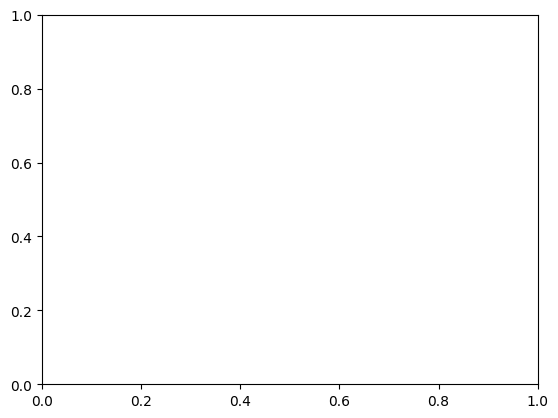

In [25]:
# Check axis limits after plotting
print("\nAxis Limits:")
print(f"x-axis limits: {plt.xlim()}")
print(f"y-axis limits: {plt.ylim()}")


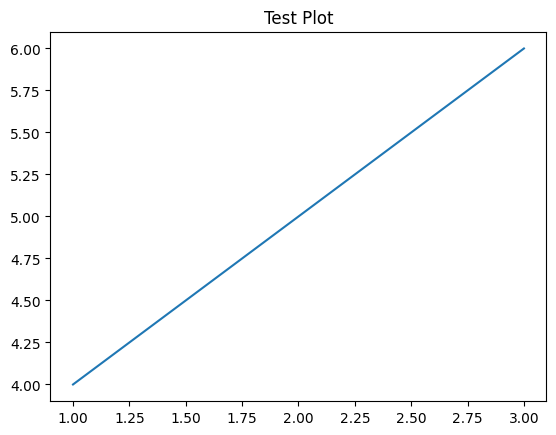

In [26]:
# Test simple plot
plt.plot([1, 2, 3], [4, 5, 6])
plt.title("Test Plot")
plt.show()


**Skill Enhancement**

In [27]:
# Insights based on analysis
print("Insights from the analysis:")
print("1. Category with the highest number of apps.")
print("2. Correlation between app size and ratings.")
print("3. Distribution of user sentiments across reviews.")


Insights from the analysis:
1. Category with the highest number of apps.
2. Correlation between app size and ratings.
3. Distribution of user sentiments across reviews.


**Detailed Sentiment Analysis**

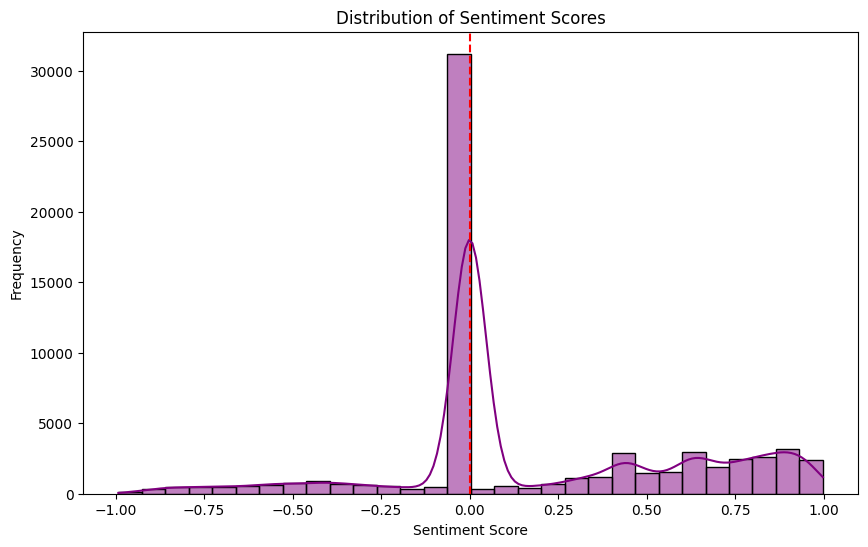

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(user_reviews_df['compound'], bins=30, kde=True, color='purple')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()


**Category Performance Analysis**

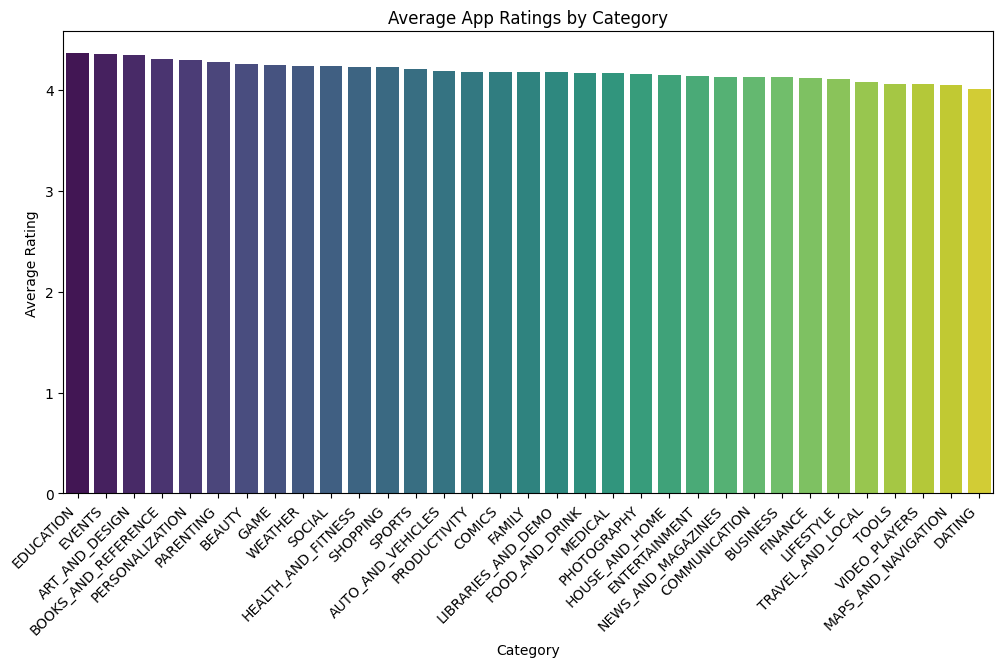

In [29]:
avg_ratings = apps_df.groupby('Category')['Rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_ratings.index, y=avg_ratings.values, hue=avg_ratings.index, palette='viridis')
plt.title('Average App Ratings by Category')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Rating')
plt.show()


In [30]:
# Display the column names in the DataFrame
print(user_reviews_df.columns)


Index(['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity', 'compound', 'sentiment'],
      dtype='object')


**Word Cloud of Reviews**

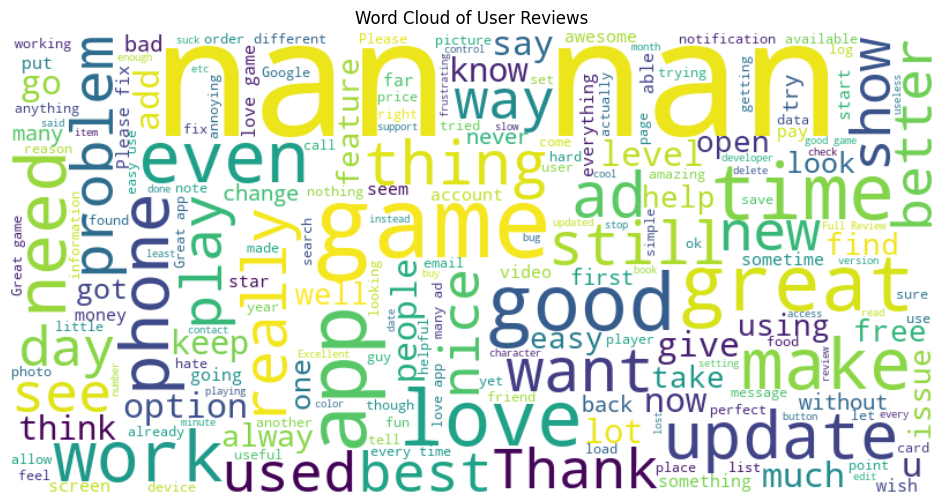

In [31]:
from wordcloud import WordCloud

text = ' '.join(user_reviews_df['Translated_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of User Reviews')
plt.show()


**Clustering Analysis**

In [32]:
print(apps_df.shape)
print(apps_df.head())


(9659, 15)
   Unnamed: 0                                                App  \
0           0     Photo Editor & Candy Camera & Grid & ScrapBook   
1           1                                Coloring book moana   
2           2  U Launcher Lite – FREE Live Cool Themes, Hide ...   
3           3                              Sketch - Draw & Paint   
4           4              Pixel Draw - Number Art Coloring Book   

         Category  Rating  Reviews  Size  Installs  Type Price Content Rating  \
0  ART_AND_DESIGN     4.1      159   NaN         0  Free     0       Everyone   
1  ART_AND_DESIGN     3.9      967   NaN         0  Free     0       Everyone   
2  ART_AND_DESIGN     4.7    87510   NaN         0  Free     0       Everyone   
3  ART_AND_DESIGN     4.5   215644   NaN         0  Free     0           Teen   
4  ART_AND_DESIGN     4.3      967   NaN         0  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & D

In [33]:
print(apps_df[['Rating', 'Size', 'Installs']].isnull().sum())


Rating         0
Size        9659
Installs       0
dtype: int64


In [34]:
cluster_data = apps_df[['Rating', 'Size', 'Installs']].dropna()
print(cluster_data.shape)
print(cluster_data.head())


(0, 3)
Empty DataFrame
Columns: [Rating, Size, Installs]
Index: []


**Violin Plot**

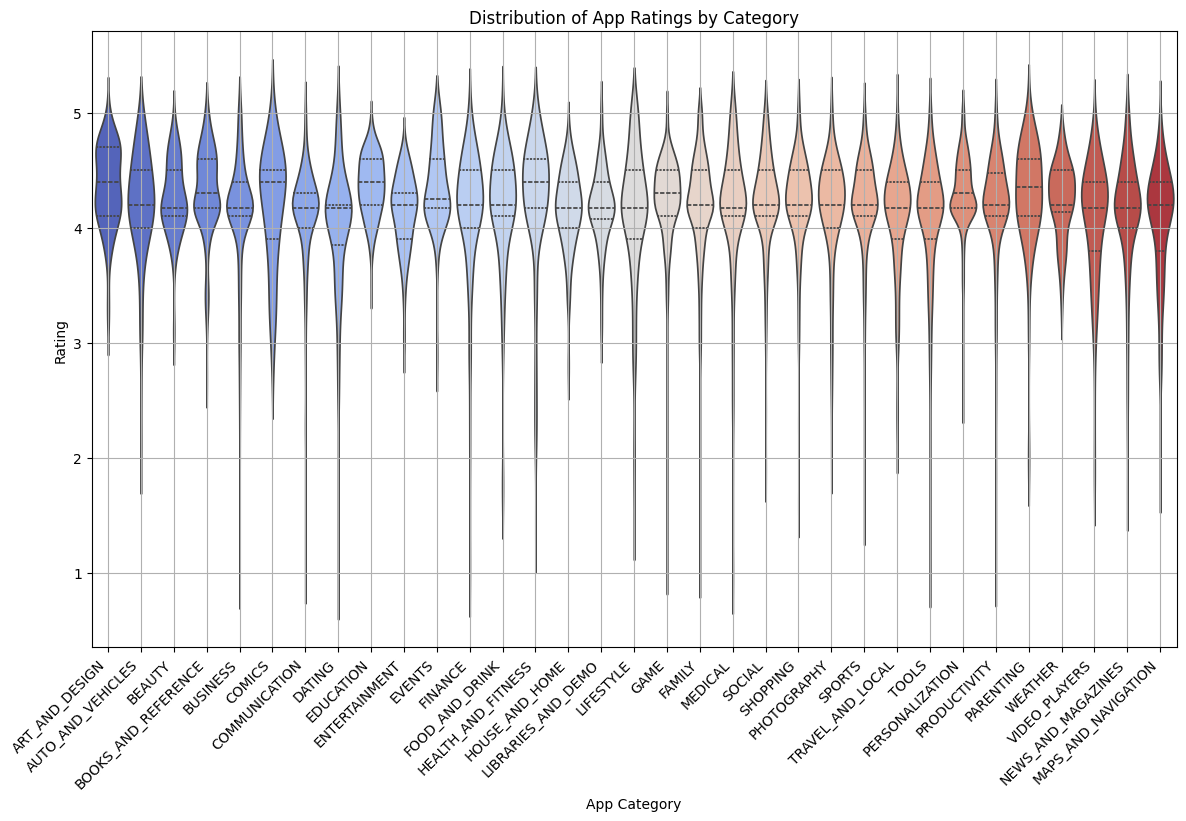

In [35]:
plt.figure(figsize=(14, 8))
sns.violinplot(data=apps_df, x='Category', y='Rating', palette='coolwarm', inner='quartile', scale='width')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of App Ratings by Category')
plt.xlabel('App Category')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


**Scatter Plot with Linear Regression Lines**

<Figure size 1000x600 with 0 Axes>

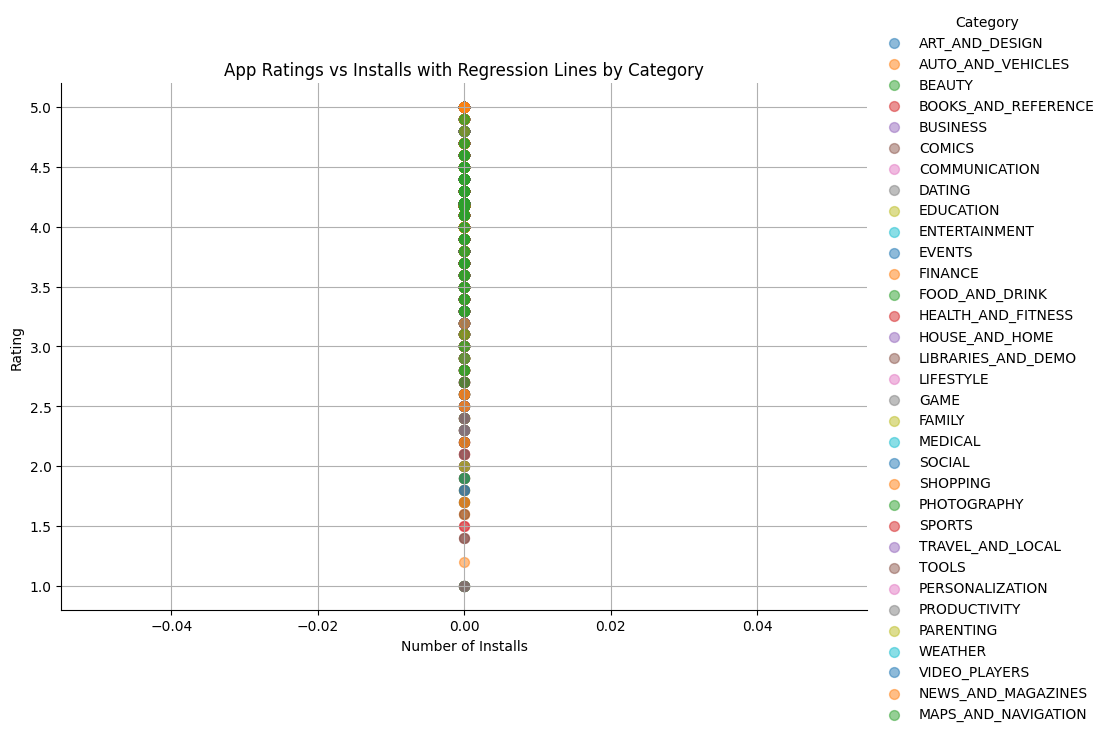

In [36]:
plt.figure(figsize=(10, 6))
sns.lmplot(data=apps_df, x='Installs', y='Rating', hue='Category', height=6, aspect=1.5, palette='tab10', scatter_kws={'s':50, 'alpha':0.5})
plt.title('App Ratings vs Installs with Regression Lines by Category')
plt.xlabel('Number of Installs')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


**Pair Plot (Scatter Plot Matrix)**

<Figure size 1200x1200 with 0 Axes>

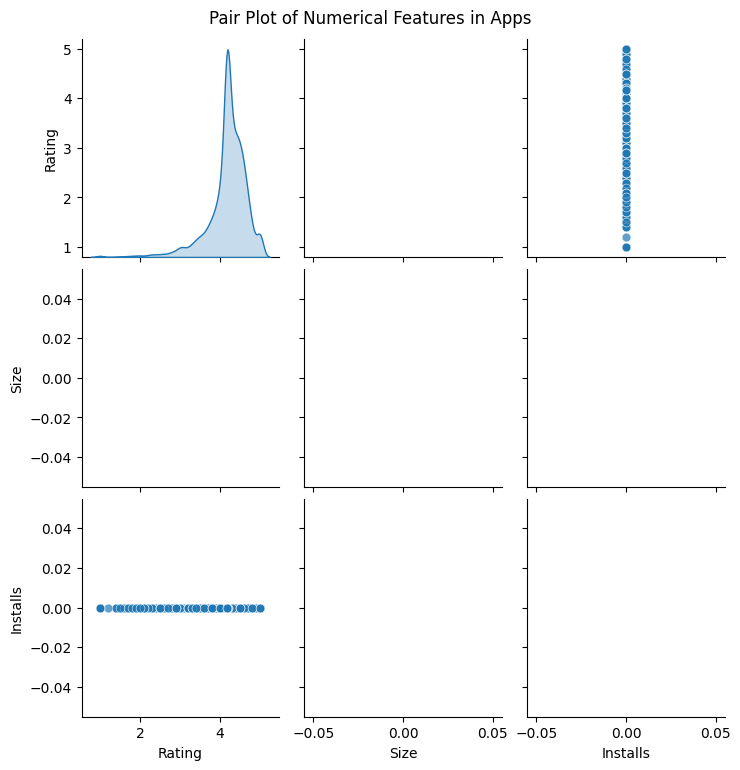

In [37]:
plt.figure(figsize=(12, 12))
sns.pairplot(apps_df[['Rating', 'Size', 'Installs', 'Price']], kind='scatter', diag_kind='kde', plot_kws={'alpha':0.7, 's':40}, palette='coolwarm')
plt.suptitle('Pair Plot of Numerical Features in Apps', y=1.02)
plt.show()


**Joint Plot with Density (Scatter + KDE)**

<Figure size 1000x600 with 0 Axes>

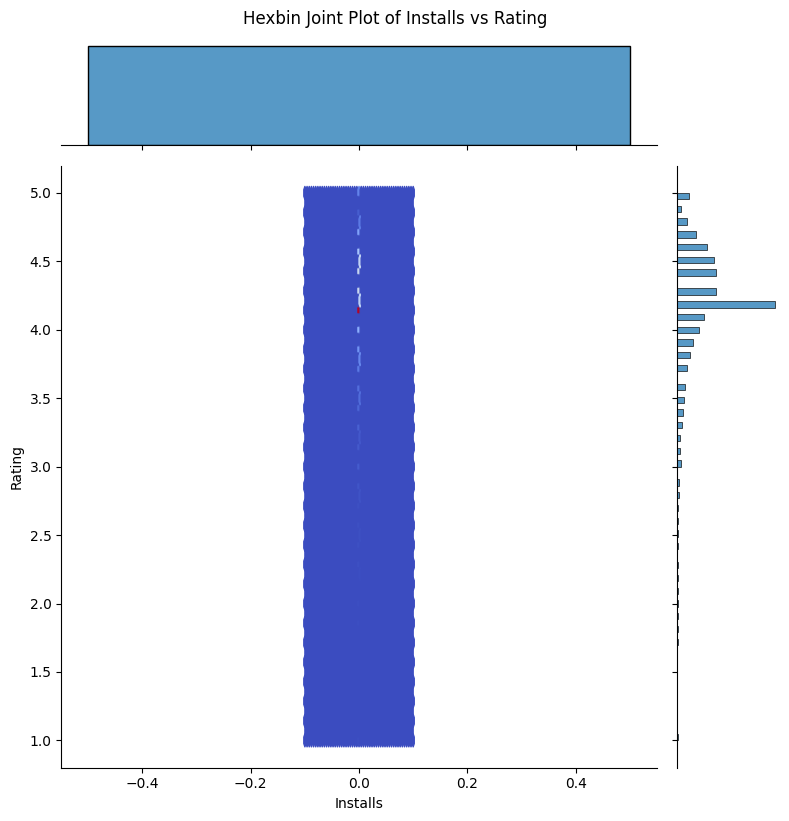

In [38]:
plt.figure(figsize=(10, 6))
sns.jointplot(data=apps_df, x='Installs', y='Rating', kind='hex', cmap='coolwarm', height=8)
plt.suptitle('Hexbin Joint Plot of Installs vs Rating', y=1.02)
plt.show()


**Strip Plot**

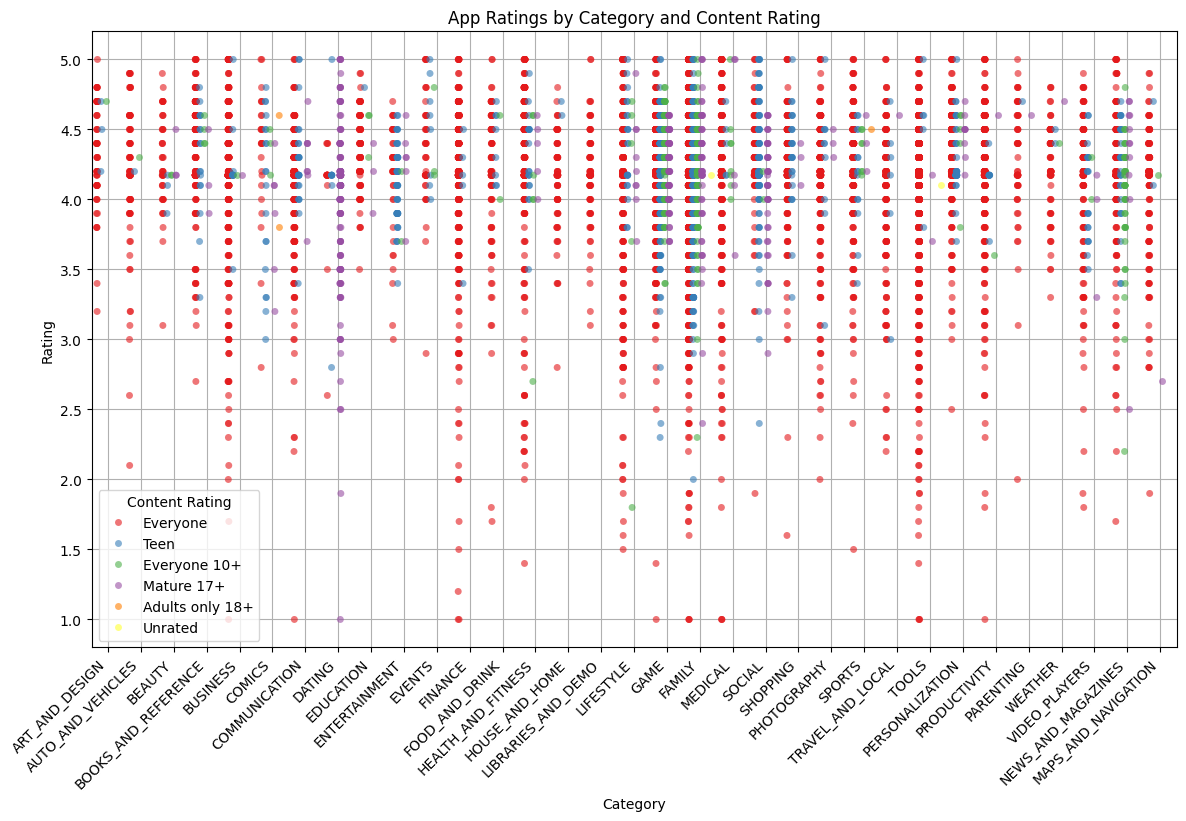

In [39]:
plt.figure(figsize=(14, 8))
sns.stripplot(data=apps_df, x='Category', y='Rating', jitter=True, hue='Content Rating', palette='Set1', dodge=True, alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.title('App Ratings by Category and Content Rating')
plt.xlabel('Category')
plt.ylabel('Rating')
plt.legend(title='Content Rating')
plt.grid(True)
plt.show()


**Box Plot with Swarm Plot**

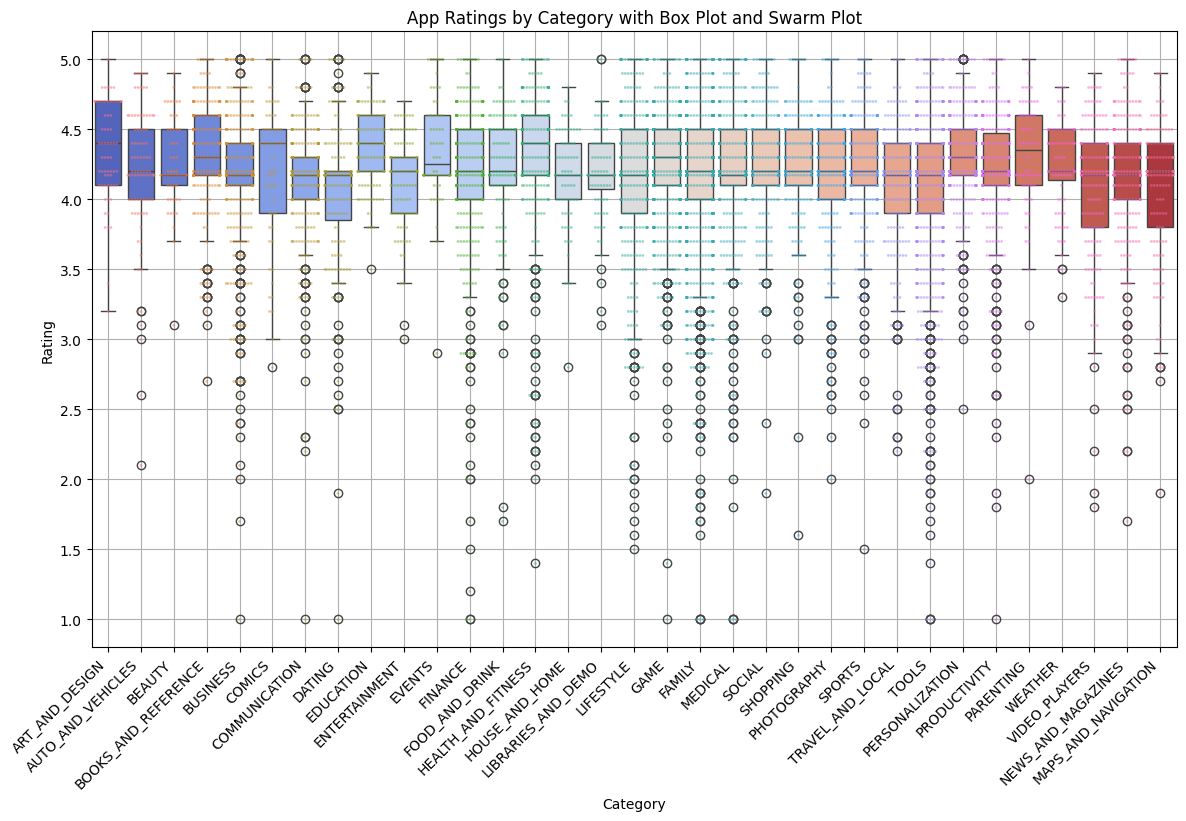

In [40]:
plt.figure(figsize=(14, 8))

# Boxplot
sns.boxplot(data=apps_df, x='Category', y='Rating', hue='Category', palette='coolwarm')

# Swarmplot - removed the color argument and reduced marker size
sns.swarmplot(data=apps_df, x='Category', y='Rating', hue='Category', size=2, alpha=0.5)

plt.xticks(rotation=45, ha='right')
plt.title('App Ratings by Category with Box Plot and Swarm Plot')
plt.grid(True)
plt.show()


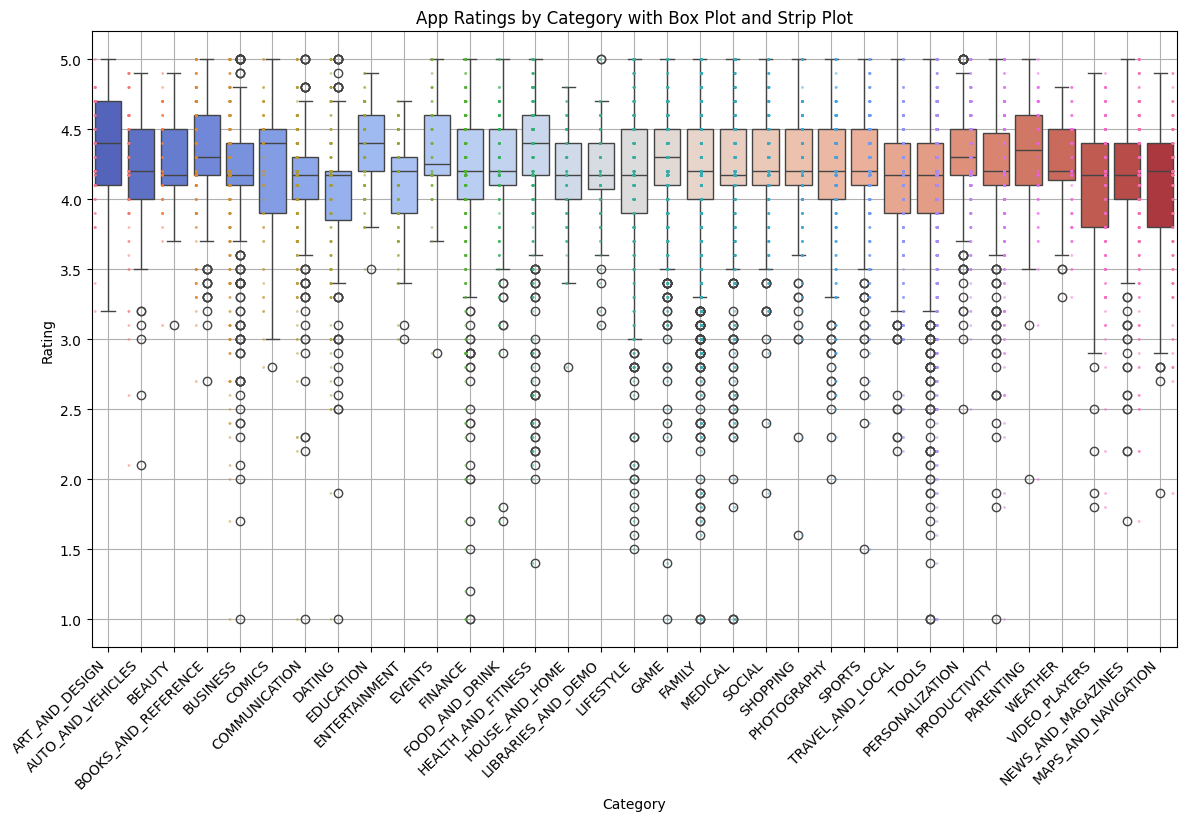

In [41]:
plt.figure(figsize=(14, 8))

# Boxplot
sns.boxplot(data=apps_df, x='Category', y='Rating', hue='Category', palette='coolwarm')

# Stripplot instead of swarmplot
sns.stripplot(data=apps_df, x='Category', y='Rating', hue='Category', size=2, alpha=0.5, dodge=True)

plt.xticks(rotation=45, ha='right')
plt.title('App Ratings by Category with Box Plot and Strip Plot')
plt.grid(True)
plt.show()


**Bar Plot with Color Gradients**

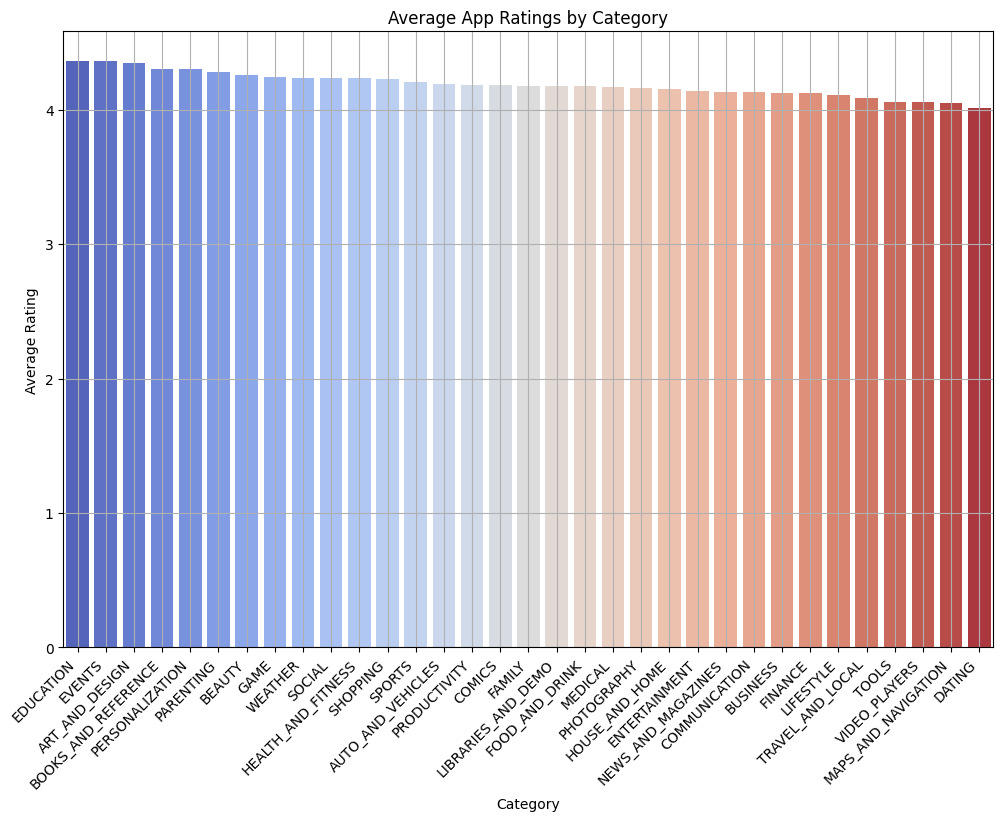

In [42]:
avg_ratings = apps_df.groupby('Category')['Rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=avg_ratings.index, y=avg_ratings.values, hue=avg_ratings.index, palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Average App Ratings by Category')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()


**Bar Plot for Average Ratings by Category**

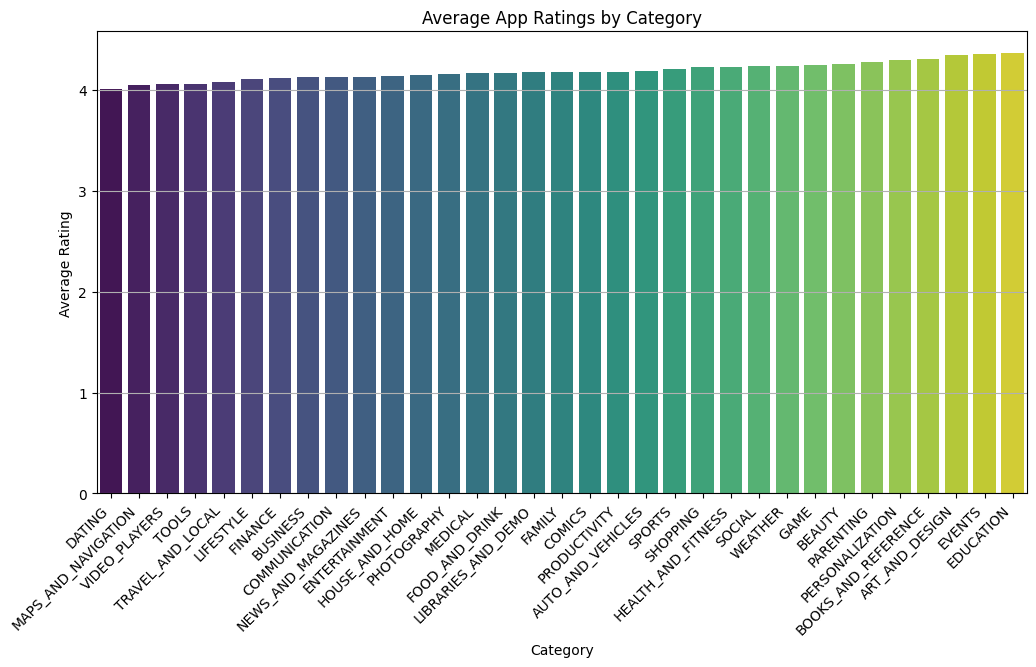

In [43]:
plt.figure(figsize=(12, 6))
avg_ratings = apps_df.groupby('Category')['Rating'].mean().sort_values()
sns.barplot(x=avg_ratings.index, y=avg_ratings.values,hue=avg_ratings.index, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Average App Ratings by Category')
plt.ylabel('Average Rating')
plt.grid(axis='y')
plt.show()


**Count Plot for Number of Apps by Category**

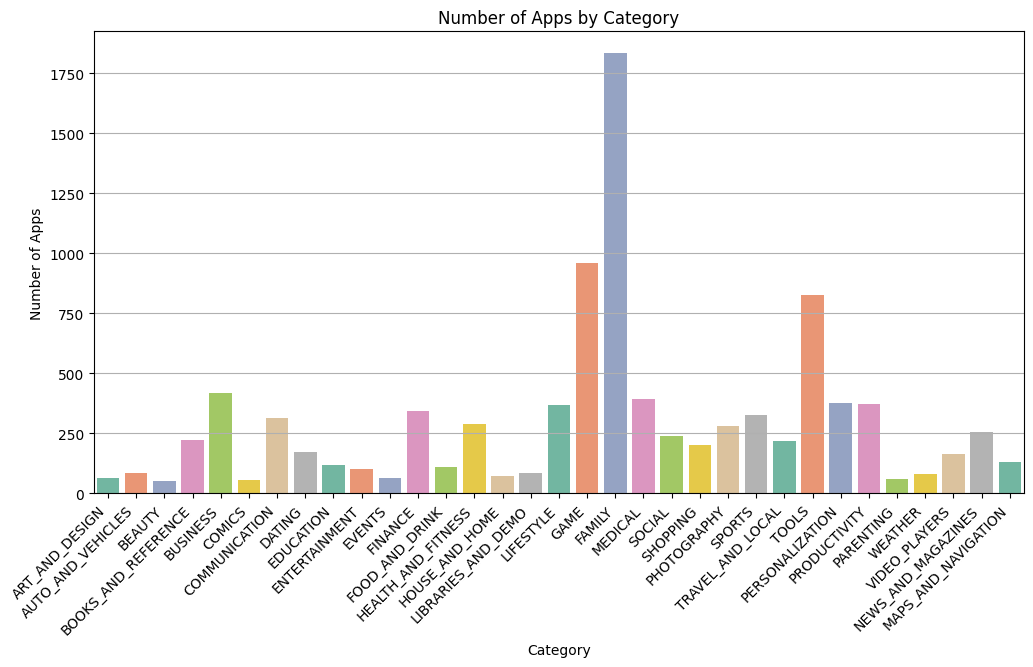

In [44]:
plt.figure(figsize=(12, 6))
sns.countplot(data=apps_df, x='Category', hue='Category',palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Apps by Category')
plt.ylabel('Number of Apps')
plt.grid(axis='y')
plt.show()


**Violin Plot for Distribution of Ratings**

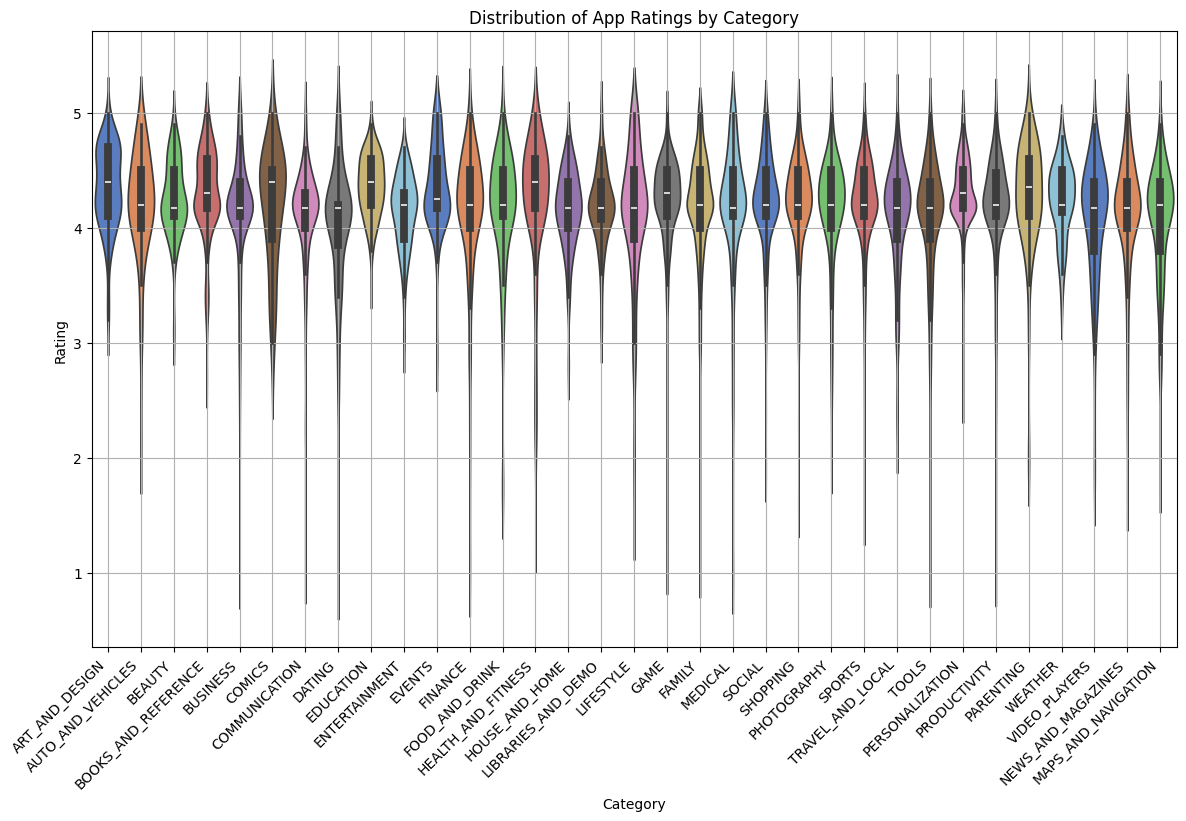

In [45]:
plt.figure(figsize=(14, 8))
sns.violinplot(data=apps_df, x='Category', y='Rating',hue='Category', palette='muted')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of App Ratings by Category')
plt.grid(True)
plt.show()


**Box Plot with Overlay of Average Ratings**

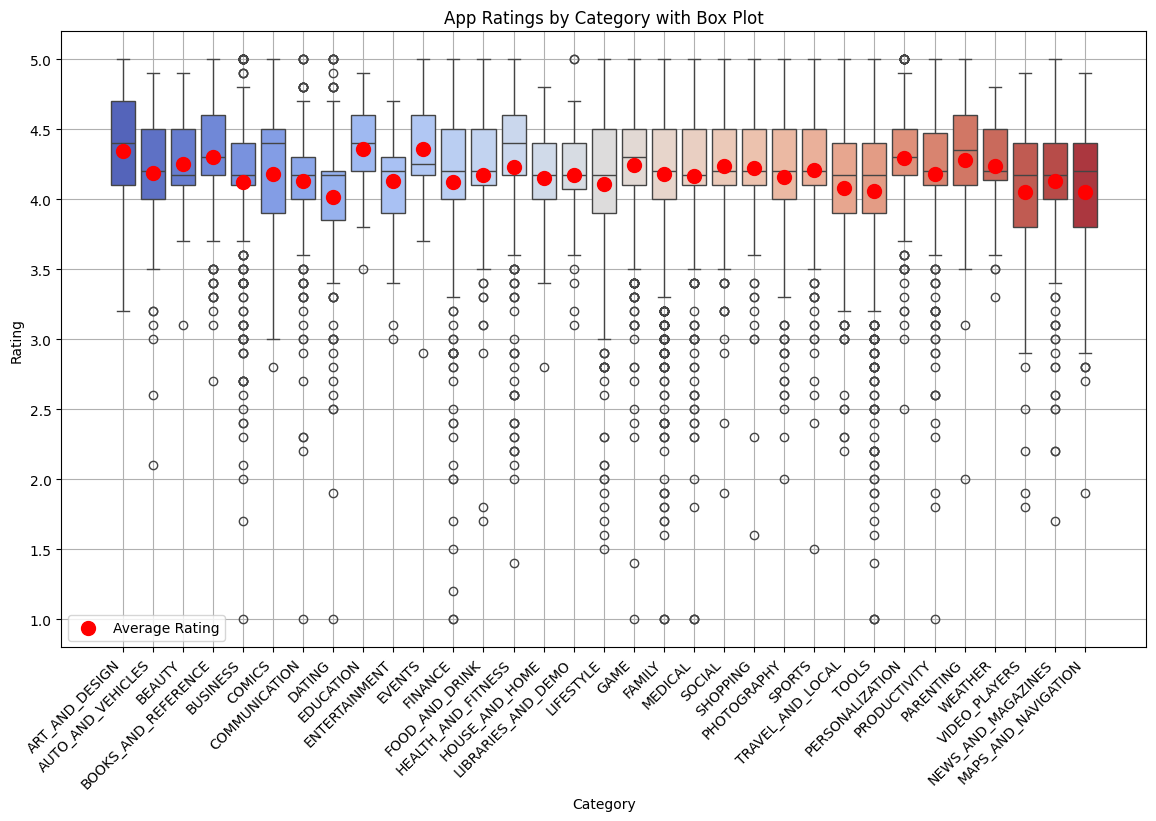

In [46]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=apps_df, x='Category', y='Rating',hue='Category', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('App Ratings by Category with Box Plot')
plt.grid(True)

# Overlaying average ratings
avg_ratings = apps_df.groupby('Category')['Rating'].mean()
plt.scatter(avg_ratings.index, avg_ratings.values, color='red', s=100, label='Average Rating', zorder=10)
plt.legend()
plt.show()
